# Лабораторная работа 4.

## Аппроксимация граничных условий второго рода в методе конечных рахностей на примере уравнения теплопроводности

**Найти приближенное решение начально-краевой задачи для уравнения теплопроводности используя явную и неявную разностные схемы:**

$$\begin{cases} 
   \frac {du}{dt}= k \cdot \frac {d^2u}{dx^2}) + f(x, t), 0 < t \leq T, a < x < b\\
   u(a, t) = g_1(t), \frac {du}{dt})(b, t) = g_2(t), 0 < t \leq T\\
   u(x, 0) = \varphi(x), a \leq x \leq b
\end{cases}$$ 

**Два способа реализации аппроксимации граничных условий второго рода:**

**1) аппроксимация производной по х левой разностью:** $\frac {dU}{dx} = \frac {U_N^n - U_{N-1}^n}{h} $

 Порядок точности - O(h).
 
 Из выражения получаем:  $U_N^n = h \cdot g_2(t) + U_{N-1}^n$.
 
**2) аппроксимация производной по х центральной  разностью:** $\frac {dU}{dx} = \frac {U_{N+1}^n - U_{N-1}^n}{2h}$

 Порядок точности - O($h^2$).
 
 Из выражения получаем: $U_{n+1}^n = 2 \cdot h \cdot g_2(t) + U_{N-1}^n$


In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt


k = 2
a, b = -1, 1
T = 0.1
n_x = 50
h = (b - a) / n_x
tau = 0.5 * (h * h / k)
n_t = int(T / tau)


f = lambda x, t: 0
fi = lambda x: x * x
g1 = lambda t: 1
g2 = lambda t: 1

### Решение с явной разностной схемой:

**Явная разностная схема для уравения:**

$y_k^v = \frac {\tau}{h^2} \cdot y_{k-1}^{v-1} + (1 - \frac {2 \cdot \tau}{h^2}) \cdot y_k^{v-1} + \frac {\tau}{h^2} \cdot y_{k+1}^{v-1} + \tau \cdot f_k^{v-1}$

In [2]:
# approximation_option - выбор способа аппраксимации ГУ (0) левой разностью, (1) центральной разностью
def explicit_scheme(approximation_option=0, local_tau=tau, local_h=h):
    if local_tau != tau:
        local_n_t = int(T / local_tau)
        local_n_x = int((b - a) / local_h)
    else:
        local_n_x = n_x
        local_n_t = n_t
    matrix = np.zeros((local_n_t, local_n_x))
    x_s = np.linspace(a, b, local_n_x)
    t_s = np.linspace(0, T, local_n_t)

    for i in range(len(t_s)):
        matrix[i][0] = g1(t_s[0])

    for x_j, x in enumerate(x_s):  # (id, item)
        matrix[0][x_j] = fi(x)

    for i in range(1, local_n_t):
        for j in range(1, local_n_x - 1):
            matrix[i][j] = local_tau * matrix[i - 1][j - 1] / local_h ** 2 + (1 - 2 * local_tau / local_h ** 2) \
                           * matrix[i - 1][j] + local_tau / local_h ** 2 * matrix[i - 1][j + 1] + local_tau \
                           * f(x_s[j], t_s[i - 1])
        if approximation_option == 0:
            matrix[i][-1] = g2(t_s[i]) * local_h + matrix[i][-2]
        else:
            matrix[i][-1] = local_tau * matrix[i - 1][-2] / local_h ** 2 + (1 - 2 * local_tau / local_h ** 2) \
                            * matrix[i - 1][-1] + local_tau / local_h ** 2 * (g2(t_s[i]) * 2 * local_h + matrix[i][-2])\
                            + local_tau * f(x_s[-1], t_s[i - 1])
    return matrix

#### Функция для вывода графиков:

In [3]:
def show(matrix, count=15):
    X = np.linspace(a, b - a, n_x)
    Y = np.linspace(0, n_t - 1, count)
    for y in Y:
        plt.plot(X, matrix[int(y)], label="t = {0} Ƭ".format(y))
    plt.grid(True)
    plt.legend()
    plt.show()

#### Первый способ аппроксимации:

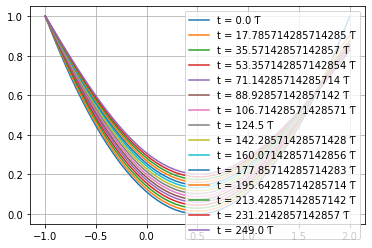

In [4]:
    matrix = explicit_scheme(approximation_option=0)
    show(matrix)

#### Второй способ аппроксимации:

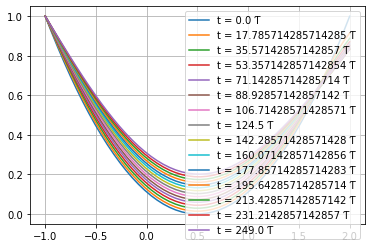

In [5]:
    matrix = explicit_scheme(approximation_option=1)
    show(matrix)

### Решение с неявной разностной схемой:

**Неявная разностная схема для уравения:**

$-y_{k}^{v-1} - \tau \cdot f_k^{v} = \frac {\tau}{h^2} \cdot y_{k-1}^{v} + (1 + \frac {2 \cdot \tau}{h^2}) \cdot y_k^v  + \frac {\tau}{h^2} \cdot y_{k+1}^{v}$

In [6]:
# approximation_option - выбор способа аппраксимации ГУ (0) левой разностью, (1) центральной разностью
def implicit_scheme(approximation_option=0, local_tau=tau, local_h=h):
    if local_tau != tau:
        local_n_t = int(T / local_tau)
        local_n_x = int((b - a) / local_h)
    else:
        local_n_x = n_x
        local_n_t = n_t
    matrix = np.zeros((local_n_t, local_n_x))
    x_s = np.linspace(a, b, local_n_x)
    t_s = np.linspace(0, T, local_n_t)

    for x_j, x in enumerate(x_s):
        matrix[0][x_j] = fi(x)

    for i in range(1, local_n_t):
        if approximation_option == 0:  # Настройка начальных данных в зависимости от способа аппроксимации
            M = np.zeros((local_n_x, local_n_x))
            H = np.zeros(local_n_x)
            M[-1][-2] = -1
            H[-1] = local_h * g2(t_s[i])
        else:
            M = np.zeros((local_n_x + 1, local_n_x + 1))
            H = np.zeros(local_n_x + 1)
            H[-1] = 2 * local_h * g2(t_s[i])
            M[-1][-3] = -1

        H[0] = g1(x_s[0])
        M[0][0] = 1
        M[-1][-1] = 1

        for j in range(1, H.shape[0] - 1):
            M[j][j - 1] = -k / local_h ** 2
            M[j][j + 1] = -k / local_h ** 2
            M[j][j] = 1 / local_tau + 2 * k / local_h ** 2
            H[j] = f(x_s[j], t_s[i]) + matrix[i - 1, j] / local_tau

        if approximation_option == 0:
            matrix[i] = np.linalg.solve(M, H)
        else:
            matrix[i] = np.linalg.solve(M, H)[:-1]
    return matrix

#### Функция для вывода графиков:

In [7]:
def show(matrix, count=15):
    X = np.linspace(a, b - a, n_x)
    Y = np.linspace(0, n_t - 1, count)
    for y in Y:
        plt.plot(X, matrix[int(y)], label="t = {0} Ƭ".format(y))
    plt.grid(True)
    plt.legend()
    plt.show()

#### Первый способ аппроксимации:

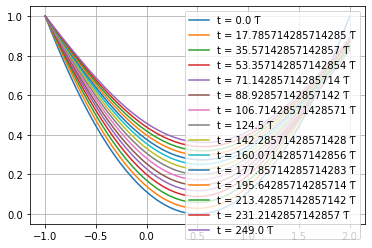

In [8]:
    matrix = implicit_scheme(approximation_option=0)
    show(matrix)

#### Второй способ аппроксимации:

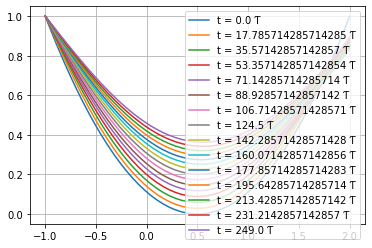

In [9]:
    matrix = implicit_scheme(approximation_option=1)
    show(matrix)

### Таблицы:

In [10]:
import pandas as pd

### Результаты при фиксированном h:

##### Функция для составления таблиц:

In [11]:
def get_table_h(method=0, approximation_option=0):
    n = 5
    local_h = (b - a) / n_x
    local_tau = h ** 2
    tau_array = []
    n_array = []
    max_t1 = []
    max_t2 = []
    s_t1 = []
    s_t2 = []
    t_s = np.linspace(0, T, n_t)
    t_indexes = np.random.randint(0, len(t_s), size=2)
    t_values = t_s[t_indexes]
    print("Значений tn1 = {} и tn2 = {}: ".format(t_values[0], t_values[1]))

    def values_for_tables(t_index, self_method, self_approximation_option, self_local_tau, self_local_h):
        matrix_1, matrix_2 = 0, 0
        if self_method == 0 and self_approximation_option == 0:
            matrix_1 = explicit_scheme(0, local_tau=self_local_tau, local_h=self_local_h)
            matrix_2 = explicit_scheme(0, local_tau=self_local_tau / 2, local_h=self_local_h)
        elif self_method == 0 and self_approximation_option == 1:
            matrix_1 = explicit_scheme(1, local_tau=self_local_tau, local_h=self_local_h)
            matrix_2 = explicit_scheme(1, local_tau=self_local_tau / 2, local_h=self_local_h)
        elif self_method == 1 and self_approximation_option == 0:
            matrix_1 = implicit_scheme(0, local_tau=self_local_tau, local_h=self_local_h)
            matrix_2 = implicit_scheme(0, local_tau=self_local_tau / 2, local_h=self_local_h)
        elif self_method == 1 and self_approximation_option == 1:
            matrix_1 = implicit_scheme(1, local_tau=self_local_tau, local_h=self_local_h)
            matrix_2 = implicit_scheme(1, local_tau=self_local_tau / 2, local_h=self_local_h)
        return matrix_1[t_index] - matrix_2[2 * t_index]

    for i in range(0, n):
        n_array.append(n_x)
        t_indexes[0] = int(t_values[0] / local_tau)
        t_indexes[1] = int(t_values[1] / local_tau)
        tau_array.append(local_tau)
        diff_t1 = values_for_tables(t_indexes[0], method, approximation_option, local_tau, local_h)
        diff_t2 = values_for_tables(t_indexes[1], method, approximation_option, local_tau, local_h)
        std_t1 = diff_t1.std()
        std_t2 = diff_t2.std()
        max_t1_item = max(diff_t1)
        max_t2_item = max(diff_t2)
        s_t1.append(round(std_t1, 7))
        s_t2.append(round(std_t2, 7))
        max_t1.append(round(max_t1_item, 7))
        max_t2.append(round(max_t2_item, 7))
        local_tau /= 2
    data = {"N": n_array,
            "tau": tau_array,
            "s(t = tn1)": s_t1,
            "s(t = tn2)": s_t2,
            "max(t = t1)": max_t1,
            "max(t = t2)": max_t2}

    print(pd.DataFrame(data))

#### Явная схема первый способ аппроксимации ГУ второго рода (точность способа - O(h)):

In [12]:
get_table_h(method=0, approximation_option=0)

Значений tn1 = 0.08072289156626507 и tn2 = 0.045381526104417674: 
    N     tau    s(t = tn1)    s(t = tn2)   max(t = t1)   max(t = t2)
0  50  0.0016  6.663076e+18  3.338996e+08  1.776879e+19  9.975887e+08
1  50  0.0008  2.026000e-04  2.787000e-04  6.030000e-04  8.109000e-04
2  50  0.0004  1.007000e-04  1.382000e-04  2.984000e-04  3.982000e-04
3  50  0.0002  5.020000e-05  6.900000e-05  1.489000e-04  1.989000e-04
4  50  0.0001  2.510000e-05  3.440000e-05  7.440000e-05  9.930000e-05


#### Явная схема второй способ аппроксимации ГУ второго рода (точность способа - O($h^2$)):

In [13]:
get_table_h(method=0, approximation_option=1)

Значений tn1 = 0.042168674698795185 и tn2 = 0.004016064257028113: 
    N     tau    s(t = tn1)  s(t = tn2)   max(t = t1)  max(t = t2)
0  50  0.0016  1.191654e+08    0.006444  3.725672e+08     0.012750
1  50  0.0008  7.114000e-04    0.000746  1.023000e-04     0.001039
2  50  0.0004  3.471000e-04    0.000324  5.050000e-05     0.000189
3  50  0.0002  1.717000e-04    0.000155  2.520000e-05     0.000084
4  50  0.0001  8.540000e-05    0.000076  1.260000e-05     0.000040


#### Неявная схема первый способ аппроксимации ГУ второго рода (точность способа - O(h)):

In [14]:
get_table_h(method=1, approximation_option=0)

Значений tn1 = 0.010040160642570281 и tn2 = 0.05823293172690763: 
    N     tau  s(t = tn1)  s(t = tn2)  max(t = t1)  max(t = t2)
0  50  0.0016    0.000461    0.000367     0.001569     0.000658
1  50  0.0008    0.000237    0.000184     0.000793     0.000330
2  50  0.0004    0.000119    0.000092     0.000391     0.000164
3  50  0.0002    0.000060    0.000046     0.000196     0.000082
4  50  0.0001    0.000030    0.000023     0.000098     0.000041


#### Неявная схема второй способ аппроксимации ГУ второго рода (точность способа - O($h^2$)):

In [15]:
get_table_h(method=1, approximation_option=1)

Значений tn1 = 0.0823293172690763 и tn2 = 0.05261044176706828: 
    N     tau  s(t = tn1)  s(t = tn2)  max(t = t1)  max(t = t2)
0  50  0.0016    0.000372    0.000363     0.000567     0.000733
1  50  0.0008    0.000187    0.000183     0.000284     0.000364
2  50  0.0004    0.000094    0.000092     0.000142     0.000182
3  50  0.0002    0.000047    0.000046     0.000071     0.000091
4  50  0.0001    0.000023    0.000023     0.000035     0.000045


### Результаты при фиксированном значении $\tau$:

##### Функция для составления таблиц:

In [23]:
def get_table_t(method=0, approximation_option=0, local_h=0.1, local_tau=0.001):
    n = 5
    length = 10
    h_array = []
    n_array = []
    s_t1 = []
    s_t2 = []
    max_t1 = []
    max_t2 = []
    N_t = int(T / local_tau)
    t_s = np.linspace(0, T, N_t)
    t_indexes = np.random.randint(0, len(t_s), size=2)
    t_values = t_s[t_indexes]
    t_indexes[0] = int(t_values[0] / local_tau)
    t_indexes[1] = int(t_values[1] / local_tau)
    print("Значений tn1 = {} и tn2 = {}: ".format(t_values[0], t_values[1]))

    def values_for_tables(t_index, self_method, self_approximation_option, self_local_tau, self_local_h):
        matrix_1, matrix_2 = 0, 0
        if self_method == 0 and self_approximation_option == 0:
            matrix_1 = explicit_scheme(0, local_tau=self_local_tau, local_h=self_local_h)
            matrix_2 = explicit_scheme(0, local_tau=self_local_tau, local_h=self_local_h / 2)
        elif self_method == 0 and self_approximation_option == 1:
            matrix_1 = explicit_scheme(1, local_tau=self_local_tau, local_h=self_local_h)
            matrix_2 = explicit_scheme(1, local_tau=self_local_tau, local_h=self_local_h / 2)
        elif self_method == 1 and self_approximation_option == 0:
            matrix_1 = implicit_scheme(0, local_tau=self_local_tau, local_h=self_local_h)
            matrix_2 = implicit_scheme(0, local_tau=self_local_tau, local_h=self_local_h / 2)
        elif self_method == 1 and self_approximation_option == 1:
            matrix_1 = implicit_scheme(1, local_tau=self_local_tau, local_h=self_local_h)
            matrix_2 = implicit_scheme(1, local_tau=self_local_tau, local_h=self_local_h / 2)
        return matrix_1[t_index] - matrix_2[t_index][1::2]

    for i in range(0, n):
        n_array.append((b - a) / local_h)
        h_array.append(local_h)
        diff_t1 = values_for_tables(t_indexes[0], method, approximation_option, local_tau, local_h)
        diff_t2 = values_for_tables(t_indexes[1], method, approximation_option, local_tau, local_h)
        std_t1 = diff_t1.std()
        std_t2 = diff_t2.std()
        max_t1_item = max(diff_t1)
        max_t2_item = max(diff_t2)
        s_t1.append(round(std_t1, length))
        s_t2.append(round(std_t2, length))
        max_t1.append(round(max_t1_item, length))
        max_t2.append(round(max_t2_item, length))
        local_h /= 2
    data = {"N": n_array,
            "h": h_array,
            "s(t = tn1)": s_t1,
            "s(t = tn2)": s_t2,
            "max(t = t1)": max_t1,
            "max(t = t2)": max_t2}

    print(pd.DataFrame(data))

#### Явная схема первый способ аппроксимации ГУ второго рода (точность способа - O(h)):

In [24]:
get_table_t(method=0, approximation_option=0, local_h=0.5)

Значений tn1 = 0.05858585858585859 и tn2 = 0.011111111111111112: 
      N        h    s(t = tn1)    s(t = tn2)   max(t = t1)   max(t = t2)
0   4.0  0.50000  1.705406e-01  2.290739e-01  3.812237e-01  4.631559e-01
1   8.0  0.25000  8.334411e-02  1.009890e-01  1.878980e-01  2.295705e-01
2  16.0  0.12500  3.951566e-02  4.506978e-02  9.260688e-02  1.127472e-01
3  32.0  0.06250  1.491844e+23  5.295195e+00  6.340354e+22  2.131850e+01
4  64.0  0.03125  3.313614e+62  2.182314e+07  3.463849e+62  1.200884e+08


#### Явная схема второй способ аппроксимации ГУ второго рода (точность способа - O($h^2$)):

In [25]:
get_table_t(method=0, approximation_option=1, local_h=0.5)

Значений tn1 = 0.08686868686868687 и tn2 = 0.07676767676767676: 
      N        h    s(t = tn1)    s(t = tn2)   max(t = t1)   max(t = t2)
0   4.0  0.50000  1.321756e-01  1.387065e-01  3.450966e-01  3.572914e-01
1   8.0  0.25000  6.637983e-02  6.858199e-02  1.713389e-01  1.769006e-01
2  16.0  0.12500  3.256956e-02  3.351860e-02  8.476888e-02  8.739827e-02
3  32.0  0.06250  1.758346e+37  2.414723e+32  6.010742e+36  8.971777e+31
4  64.0  0.03125  1.439251e+96  2.140852e+84  1.274327e+96  2.070132e+84


#### Неявная схема первый способ аппроксимации ГУ второго рода (точность способа - O(h)):

In [27]:
get_table_t(method=1, approximation_option=0)

Значений tn1 = 0.03333333333333333 и tn2 = 0.06060606060606061: 
       N        h  s(t = tn1)  s(t = tn2)  max(t = t1)  max(t = t2)
0   20.0  0.10000    0.030561    0.026114     0.072112     0.061491
1   40.0  0.05000    0.014904    0.012919     0.035817     0.030631
2   80.0  0.02500    0.007354    0.006416     0.017845     0.015284
3  160.0  0.01250    0.003652    0.003196     0.008907     0.007634
4  320.0  0.00625    0.001820    0.001595     0.004449     0.003815


#### Неявная схема второй способ аппроксимации ГУ второго рода (точность способа - O($h^2$)):

In [28]:
get_table_t(method=1, approximation_option=1)

Значений tn1 = 0.0707070707070707 и tn2 = 0.044444444444444446: 
       N        h  s(t = tn1)  s(t = tn2)  max(t = t1)  max(t = t2)
0   20.0  0.10000    0.022634    0.026105     0.058213     0.067390
1   40.0  0.05000    0.011302    0.012943     0.029030     0.033511
2   80.0  0.02500    0.005643    0.006440     0.014493     0.016707
3  160.0  0.01250    0.002819    0.003212     0.007241     0.008341
4  320.0  0.00625    0.001409    0.001604     0.003619     0.004167
